In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os
import re
from tqdm import tqdm, trange

#sns.set_theme()

def load_data_files(path, name=None):
    data = None
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            if data is None:
                data = run
            else:
                data = data.append(run, ignore_index=True)
    if name is not None:
        data["Name"] = name
    return data

def set_fixed_steps(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in tqdm((range(n_runs))):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range)].index)
            
            if len(ids) == 0:
                print("hin?")
                continue
                
            shuffled_ids = random.sample(ids, len(ids))
            keep_id = shuffled_ids[0]
            drop_ids += shuffled_ids[1:]
            
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in trange(n_runs):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range + 1000)].index)
            
            if len(ids) == 0:
                #print(rows, s_i, "hin?")
                continue
            
            keep_id = ids[0]
            drop_ids += ids[1:]
            # For all numerical columns but the 'Step'
            for c in data.select_dtypes(include=np.number).columns:
                if c == "Step":
                    continue
                data.at[keep_id, c] = data.loc[ids][c].mean()
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg_index(data, n_index=10, diplay_prog=True):
    drop_ids = []
    range_fn = trange if diplay_prog else range
    for i in range_fn(0, len(data), n_index):
        ids = list(range(i, min(i + n_index, len(data))))
        keep_id = ids[-1]
        drop_ids += ids[:-1]
        # For all numerical columns but the 'Step'
        for c in data.select_dtypes(include=np.number).columns:
            if c == "Step":
                continue
            data.at[keep_id, c] = data.loc[ids][c].mean()
    return data.drop(drop_ids)

def plot_runs(runs, x="Step", y="Episode return", estim="mean", err="sd", 
               ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, xlim=None,
               names=None, colors=None, loc='best', size=(15, 6)):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    if xlim is not None:
        ax.set(xlim=xlim)
    if ylim is not None:
        ax.set(ylim=ylim)
    #for r_i in range(len(runs)):
    #    sns.lineplot(data=runs[r_i], 
    #                 x=x, y=y, hue="Name", ax=ax, estimator=estim, errorbar=err, palette=colors)
    sns.lineplot(data=runs, x=x, y=y, hue="Name", 
                 ax=ax, estimator=estim, errorbar=err, 
                 palette=colors, legend="brief")
    #if names is not None:
    #    ax.legend(names, loc=loc, frameon=False)
    #else:
    ax.legend(loc=loc, frameon=False)
        
def box_plot_runs(runs, x="Step", y="Mean return", 
             ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
             legend=True, names=None, loc='best', size=(15, 6), 
             only_one_step=None, swarm=False, swarm_size=3, colors=None):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ylim is not None:
        ax.set(ylim=ylim, xlabel=ax_xlabel, ylabel=ax_ylabel)
    if only_one_step is not None:
        runs = runs.loc[runs["Step"] == only_one_step]
        x = "Name"
    if swarm:
        sns.swarmplot(x=x, y=y, hue="Name", data=runs, ax=ax, size=swarm_size, palette=colors)
        plt.setp(ax.get_xticklabels(), rotation=30)#, horizontalalignment="right")
    else:
        sns.boxplot(x=x, y=y, hue="Name", data=runs, ax=ax, palette=colors)
    if legend:
        if names is not None:
            ax.legend(names, loc=loc)
        else:
            ax.legend(loc=loc)
    else:
        ax.get_legend().remove()
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    return ax
        
def load_plot_runs(path, y="Episode extrinsic return", n_index_avg=100, separate_graphs=True, ax=None,
                   ax_xlabel=None, ax_ylabel=None):
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
        # TODO Plot single run
        
    else:
        if not separate_graphs and ax is None:
            fig, ax = plt.subplots(figsize=(15, 6))
        if ax_xlabel is not None:
            ax.set(xlabel=ax_xlabel)
        if ax_ylabel is not None:
            ax.set(ylabel=ax_ylabel)
        for file in os.listdir(path):
            print(file)
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            #run = mov_avg(run, step_range=step_range, n_runs=1)
            run = mov_avg_index(run, n_index=n_index_avg)
            if separate_graphs:
                fig, ax = plt.subplots(figsize=(15, 6))
                ax.plot(run["Step"], run[y])
                plt.show()
            else:
                ax.plot(run["Step"], run[y])
        plt.show()
        
def load_mov_avg(dir_path, name, avg_range=100000, max_steps=10000000):
    runs = []
    for file in os.listdir(dir_path):
        print(file, end=' - ')
        # Load file
        run = pd.read_csv(os.path.join(dir_path, file), index_col=0)
        # Move average
        avg_runs = []
        for s_i in range(0, max_steps, avg_range):
            range_rows = run[(run["Step"] > s_i) & (run["Step"] <= s_i + avg_range)]
            
            row = {}
            for c in run.columns:
                if c == "Step":
                    row["Step"] = s_i + avg_range
                else:
                    row[c] = range_rows[c].mean()

            avg_runs.append(row)
        runs.append(pd.DataFrame(avg_runs))
    all_runs = pd.concat(runs)
    all_runs["Name"] = name
    return all_runs

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run5.csv - 

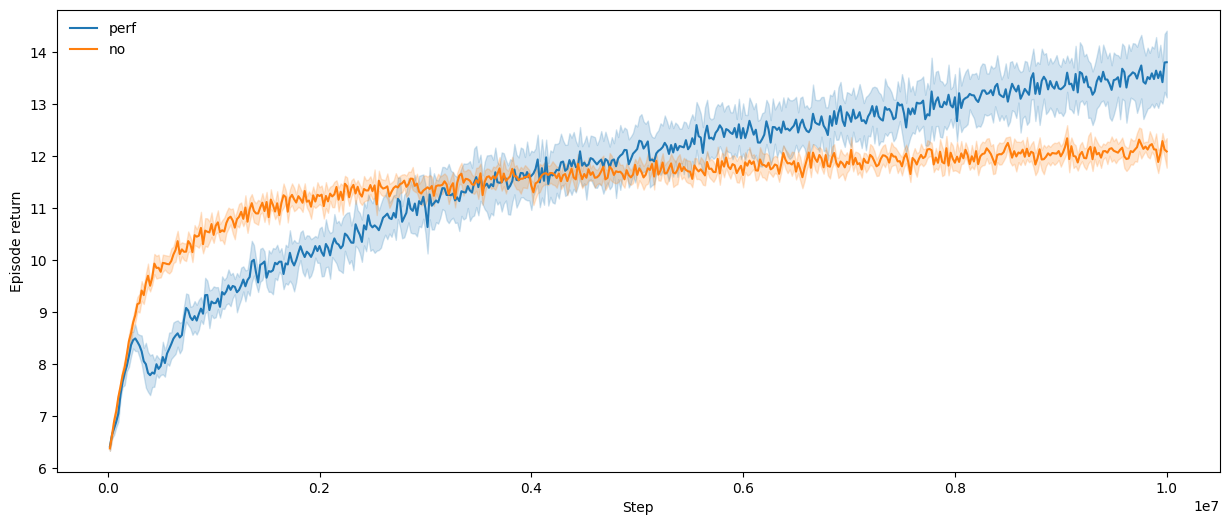

In [17]:
perf_comm = load_mov_avg(
    "../models/magym_Foraging/ACC_10x10_pt_perfect_comm/train_data/", 
    "perf", 
    20000)
no_comm = load_mov_avg(
    "../models/magym_Foraging/ACC_10x10_pt_no_comm/train_data/", 
    "no", 
    20000)

plot_runs([perf_comm, no_comm], y="Episode return", err="ci")

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run17.csv - run3.csv - run7.csv - run9.csv - run11.csv - run16.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

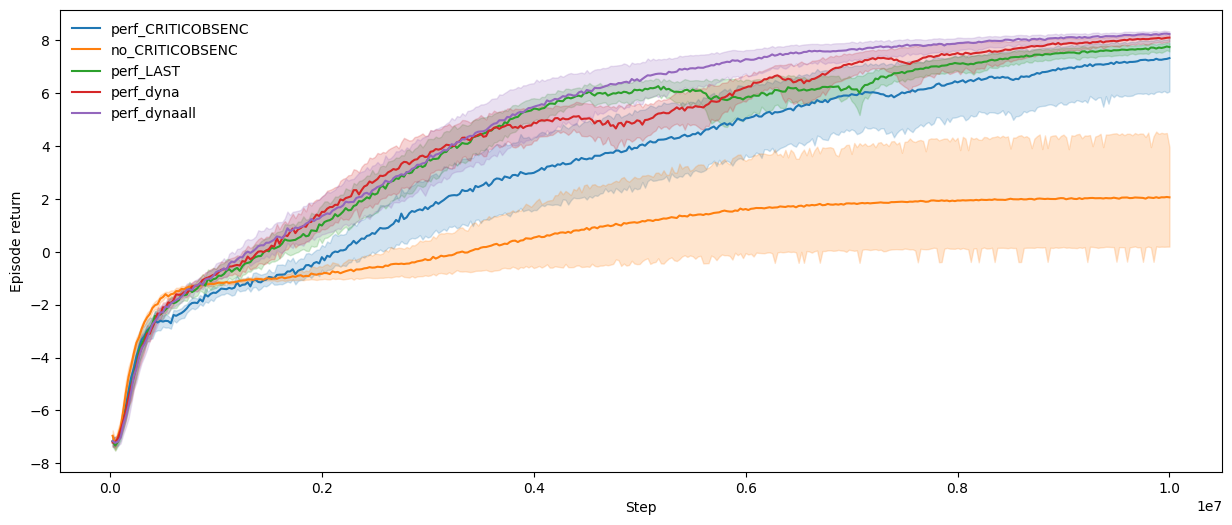

In [2]:
perf_comm = load_mov_avg(
    "../models/magym_PredPrey/ACC_9x9_perf_CRITICOBSENC/train_data/", 
    "perf_CRITICOBSENC", 
    25000)
perf_comm_new = load_mov_avg(
    "../models/magym_PredPrey/9o5_ACC_perf_weightactorloss_EMBED/train_data/", 
    "perf_LAST", 
    25000)
perf_comm_dyna = load_mov_avg(
    "../models/magym_PredPrey/ACC_9o5_perf_dynawl/train_data/", 
    "perf_dyna", 
    25000)
perf_comm_dynaall = load_mov_avg(
    "../models/magym_PredPrey/ACC_9o5_perf_alldynawl/train_data/", 
    "perf_dynaall", 
    25000)
no_comm_new = load_mov_avg(
    "../models/magym_PredPrey/ACC_9x9_no_CRITICOBSENC/train_data/", 
    "no_CRITICOBSENC", 
    25000)

plot_runs([perf_comm, no_comm_new, perf_comm_new, perf_comm_dyna, perf_comm_dynaall], y="Episode return", err="ci")

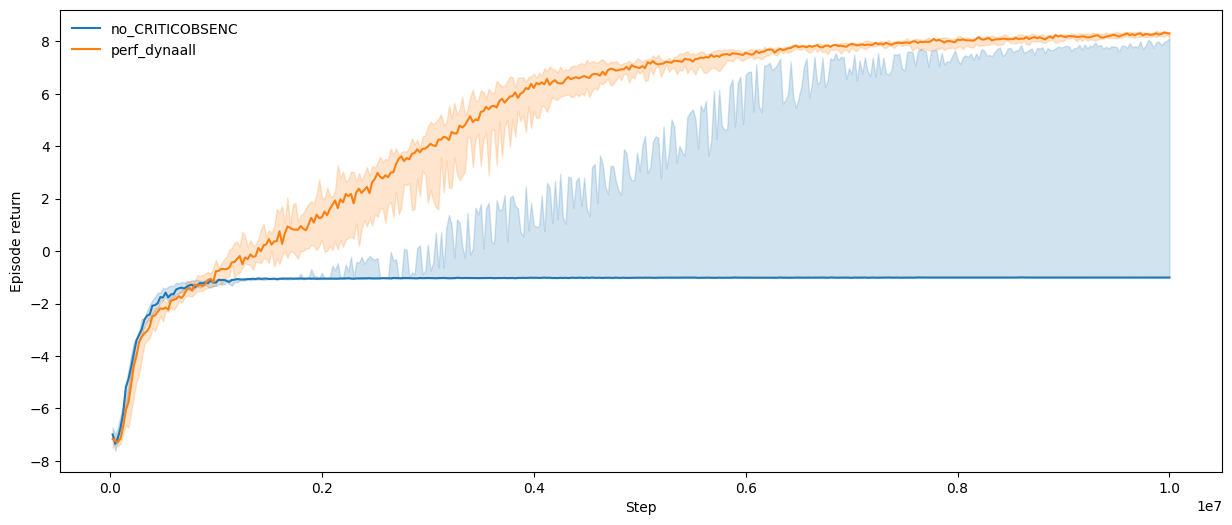

In [4]:
plot_runs([no_comm_new, perf_comm_dynaall], y="Episode return", estim="median", err="ci")

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

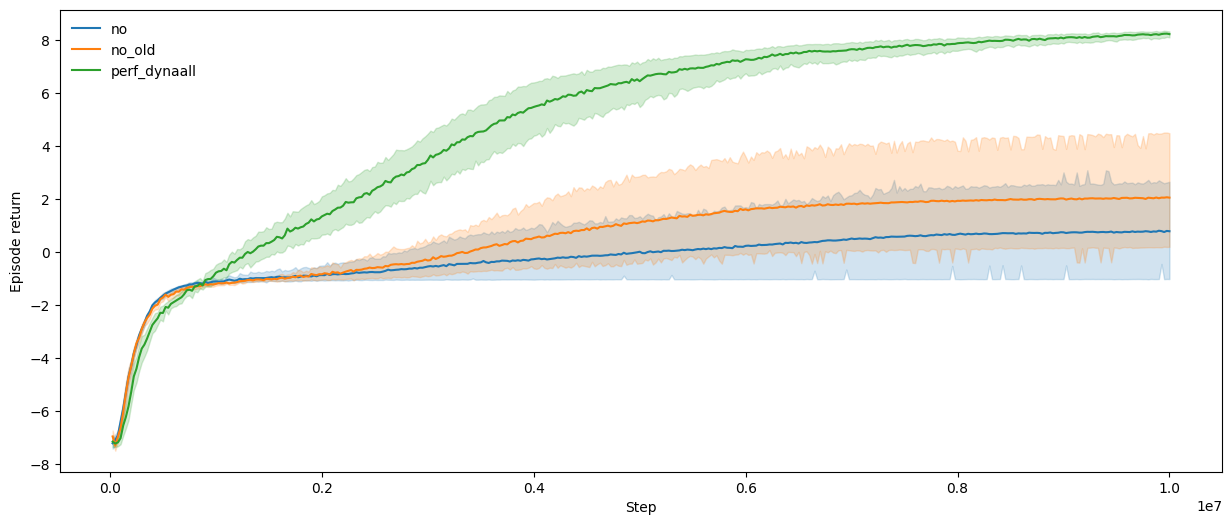

In [6]:
perf_comm_dynaall = load_mov_avg(
    "../models/magym_PredPrey/ACC_9o5_perf_alldynawl/train_data/", 
    "perf_dynaall", 
    25000)
no_comm_new = load_mov_avg(
    "../models/magym_PredPrey/9o5_ACC_no/train_data/", 
    "no", 
    25000)
no_comm_old = load_mov_avg(
    "../models/magym_PredPrey/ACC_9x9_no_CRITICOBSENC/train_data/", 
    "no_old", 
    25000)

plot_runs([no_comm_new, no_comm_old, perf_comm_dynaall], y="Episode return", err="ci")

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

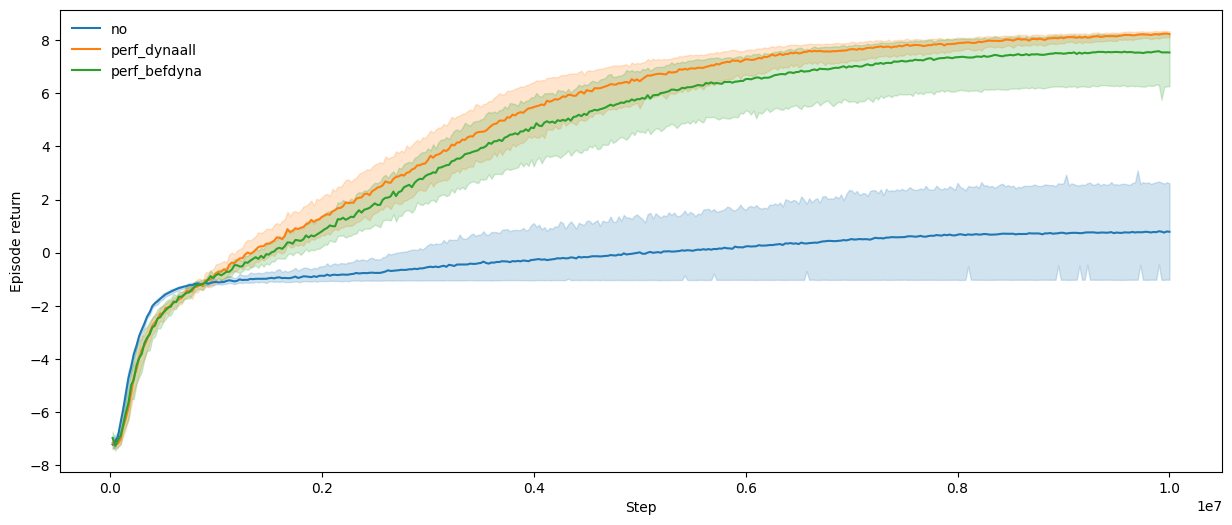

In [9]:
perf_comm_dynaall = load_mov_avg(
    "../models/magym_PredPrey/ACC_9o5_perf_alldynawl/train_data/", 
    "perf_dynaall", 
    25000)
perf_comm_befdyna = load_mov_avg(
    "../models/magym_PredPrey/9o5_ACC_perf_befdyna/train_data/", 
    "perf_befdyna", 
    25000)
no_comm_new = load_mov_avg(
    "../models/magym_PredPrey/9o5_ACC_no/train_data/", 
    "no", 
    25000)

plot_runs([no_comm_new, perf_comm_dynaall, perf_comm_befdyna], y="Episode return", err="ci")

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

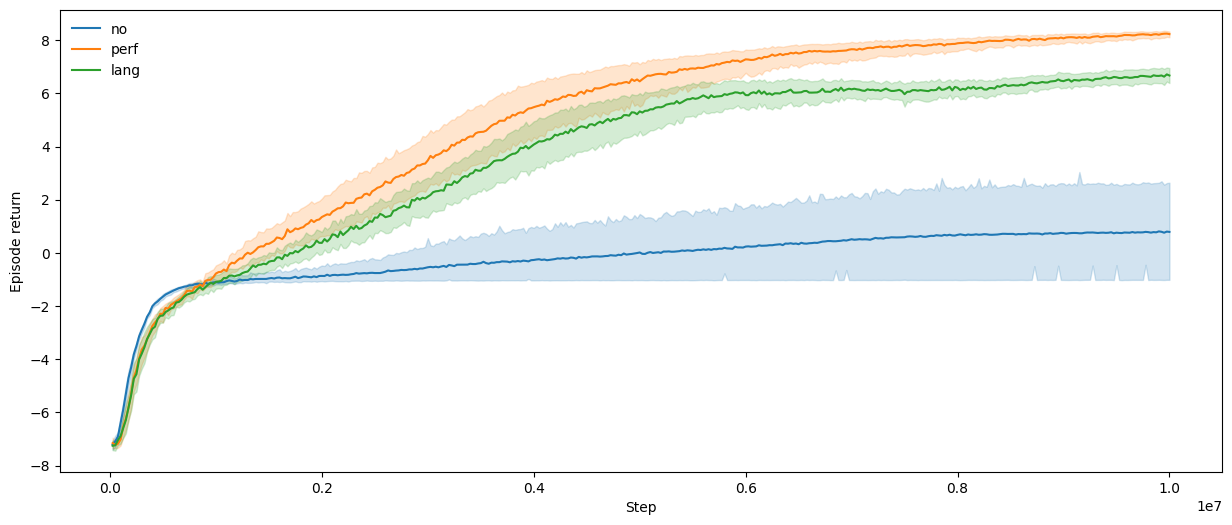

In [11]:
perf_comm_dynaall = load_mov_avg(
    "../models/magym_PredPrey/ACC_9o5_perf_alldynawl/train_data/", 
    "perf", 
    25000)
lang = load_mov_avg(
    "../models/magym_PredPrey/9o5_ACC_lang/train_data/", 
    "lang", 
    25000)
no_comm_new = load_mov_avg(
    "../models/magym_PredPrey/9o5_ACC_no/train_data/", 
    "no", 
    25000)

plot_runs([no_comm_new, perf_comm_dynaall, lang], y="Episode return", err="ci")

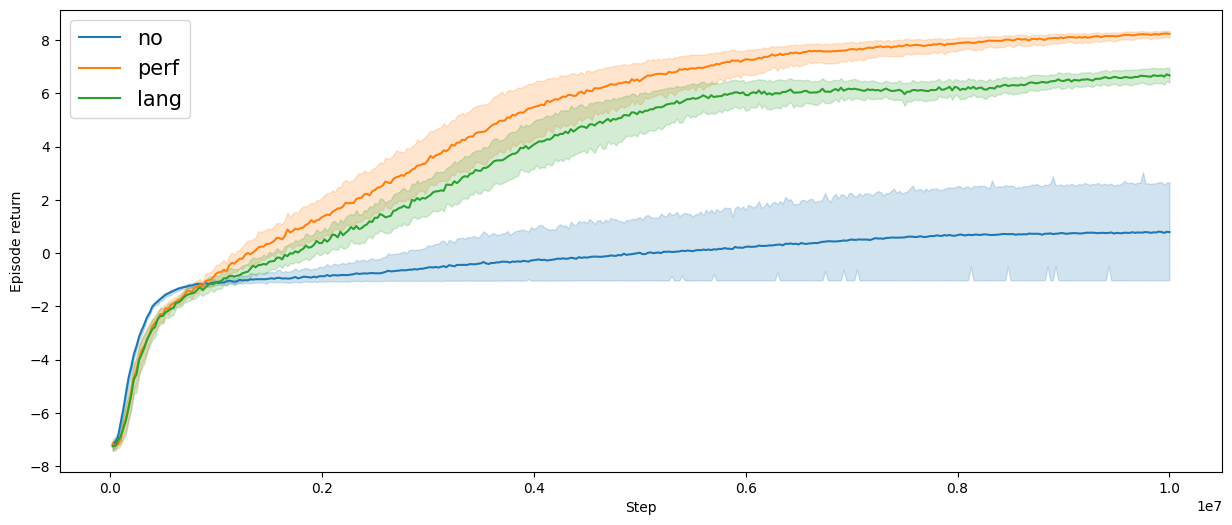

In [13]:
plot_runs([no_comm_new, perf_comm_dynaall, lang], y="Episode return", err="ci")
plt.legend(fontsize=15)

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run8.csv - run6.csv - run5.csv - 

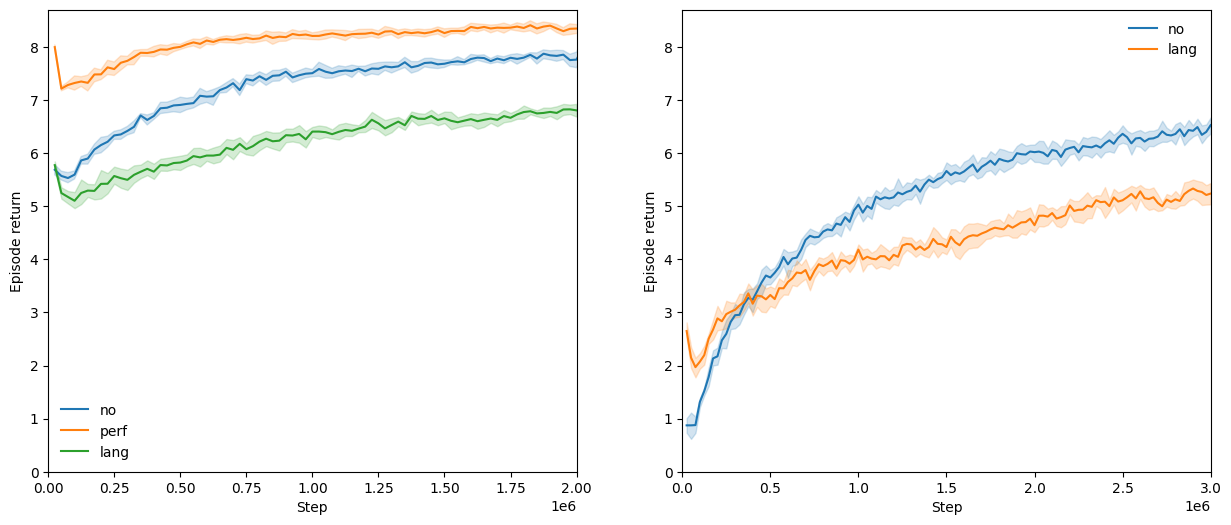

In [3]:
ad_perf_12 = load_mov_avg(
    "../models/magym_PredPrey/Adapt12_ACC_perf/train_data/", 
    "perf", 
    25000)
ad_lang_12 = load_mov_avg(
    "../models/magym_PredPrey/Adapt12_ACC_lang/train_data/", 
    "lang", 
    25000)
ad_no_12 = load_mov_avg(
    "../models/magym_PredPrey/Adapt12_ACC_no/train_data/", 
    "no", 
    25000)

ad_perf_15 = load_mov_avg(
    "../models/magym_PredPrey/Adapt15_ACC_perf/train_data/", 
    "perf", 
    25000)
ad_lang_15 = load_mov_avg(
    "../models/magym_PredPrey/Adapt15_ACC_lang/train_data/", 
    "lang", 
    25000)
ad_no_15 = load_mov_avg(
    "../models/magym_PredPrey/Adapt15_ACC_no/train_data/", 
    "no", 
    25000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_runs([ad_no_12, ad_perf_12, ad_lang_12], y="Episode return", err="ci", xlim=[0,2000000], ax=ax1, ylim=[0, 8.7])
plot_runs([ad_no_15, ad_lang_15], y="Episode return", err="ci", xlim=[0,3000000], ax=ax2, ylim=[0, 8.7])

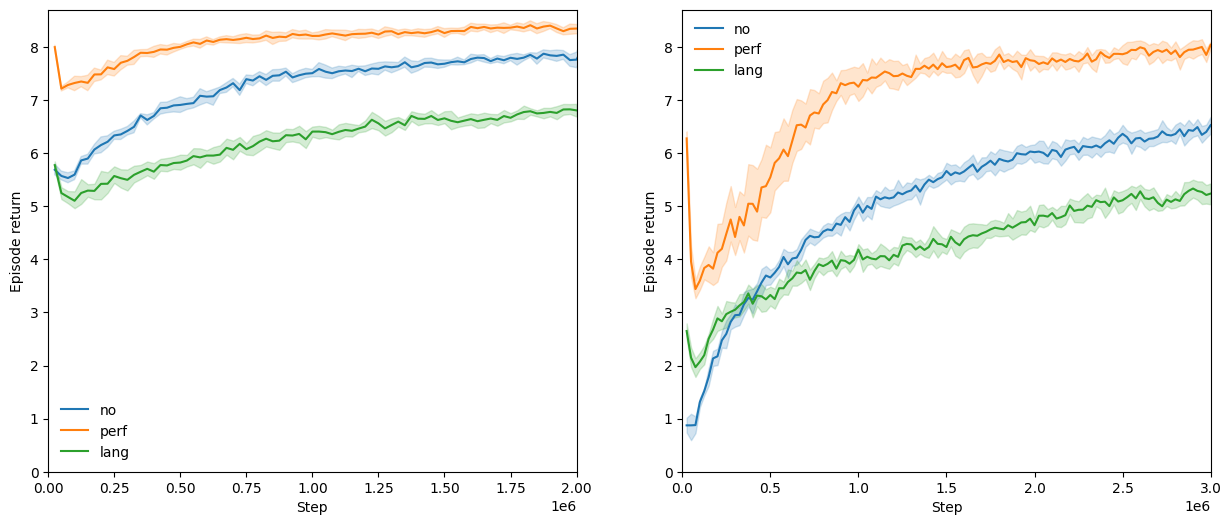

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_runs([ad_no_12, ad_perf_12, ad_lang_12], y="Episode return", err="ci", xlim=[0,2000000], ax=ax1, ylim=[0, 8.7])
plot_runs([ad_no_15, ad_perf_15, ad_lang_15], y="Episode return", err="ci", xlim=[0,3000000], ax=ax2, ylim=[0, 8.7])

In [24]:
ad_no_12[ad_no_12["Step"] == 25000]

,Step,Episode return,Success,Episode length,Name
0,25000,5.588908,0.897216,53.421842,no
0,25000,5.797656,0.922581,53.675269,no
0,25000,5.486330,0.909871,53.620172,no
0,25000,5.701692,0.877944,53.385439,no
0,25000,5.516738,0.879828,53.583691,no
0,25000,5.682797,0.891949,52.800847,no
0,25000,5.774625,0.905782,53.479657,no
0,25000,5.937076,0.921610,52.902542,no


# Differentiable architecture results

run17.csv


100%|██████████████████████████████████████| 1738/1738 [00:02<00:00, 725.98it/s]


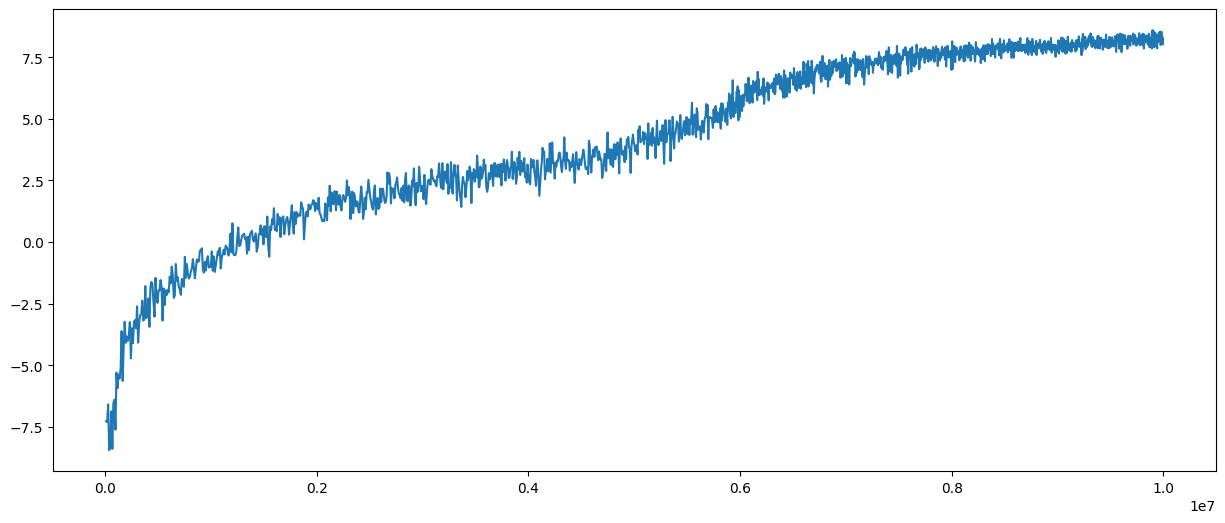

run28.csv


100%|██████████████████████████████████████| 1917/1917 [00:02<00:00, 692.59it/s]


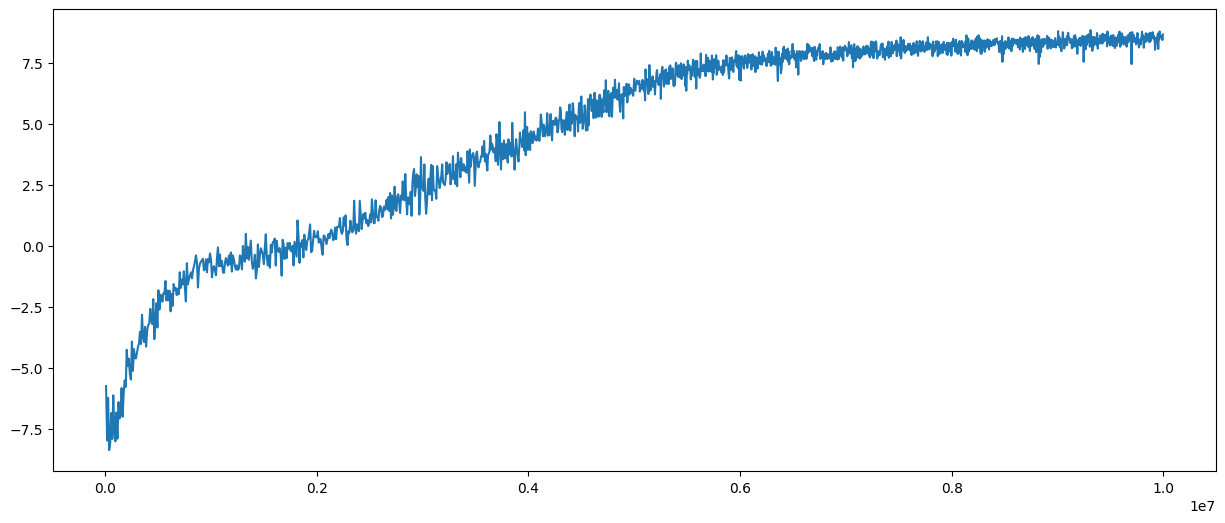

run23.csv


100%|██████████████████████████████████████| 1477/1477 [00:01<00:00, 833.97it/s]


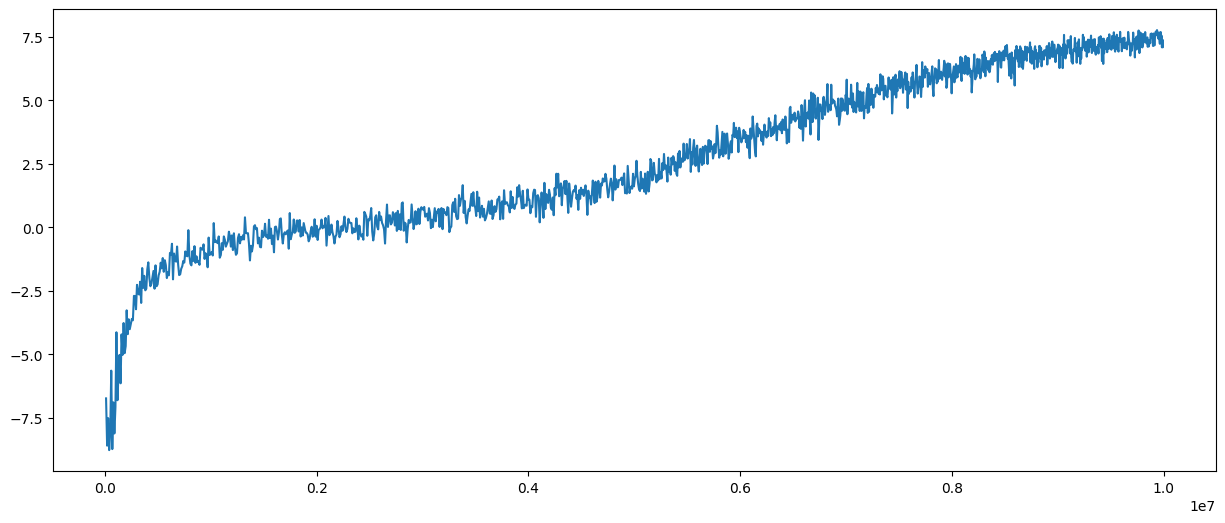

run18.csv


100%|██████████████████████████████████████| 1866/1866 [00:02<00:00, 768.99it/s]


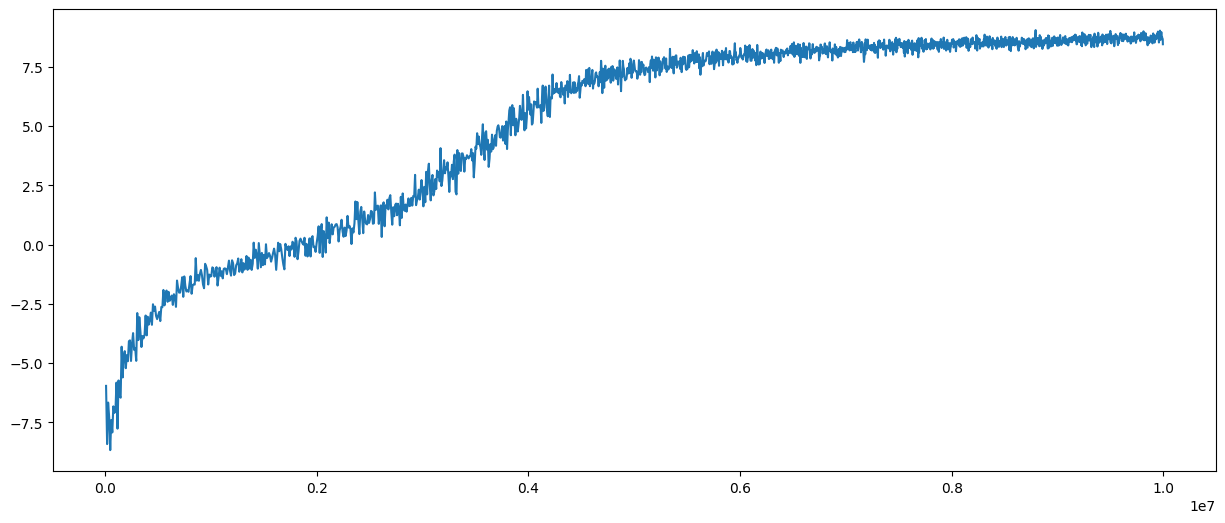

run19.csv


100%|██████████████████████████████████████| 1463/1463 [00:01<00:00, 805.31it/s]


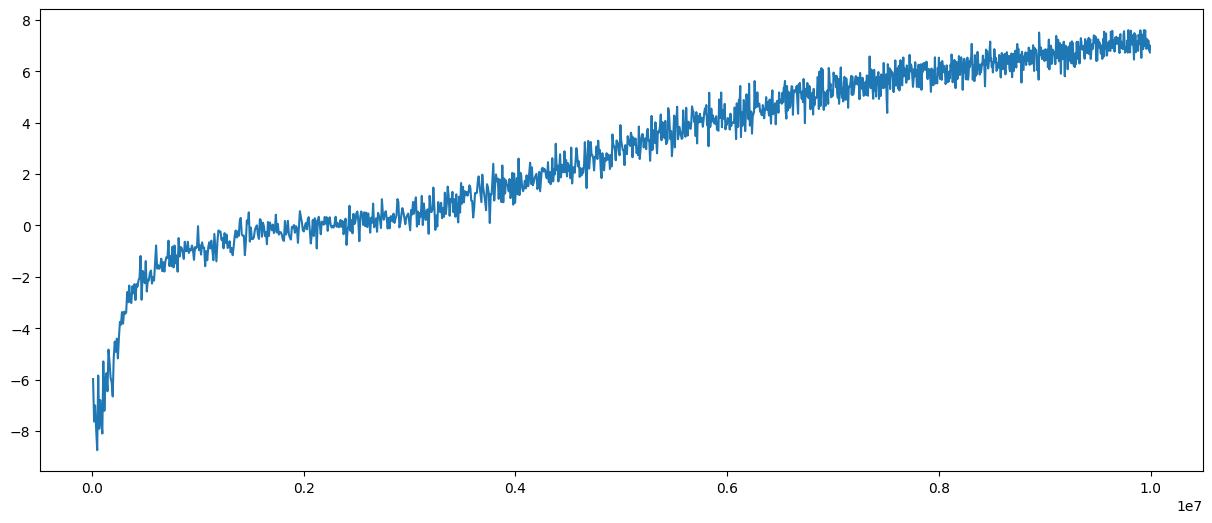

run16.csv


100%|██████████████████████████████████████| 1845/1845 [00:02<00:00, 713.10it/s]


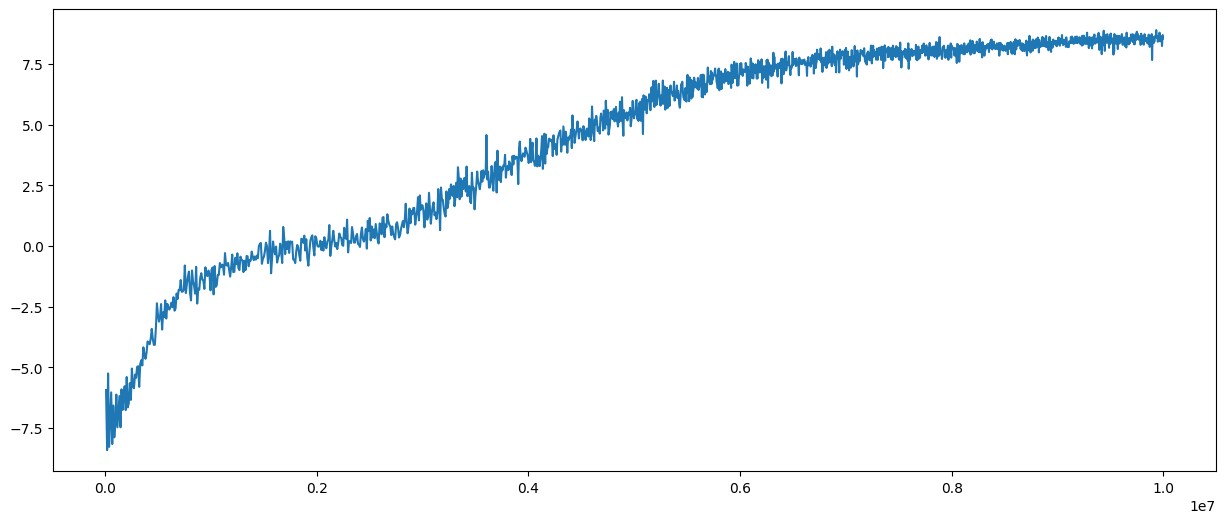

run25.csv


100%|██████████████████████████████████████| 1779/1779 [00:02<00:00, 700.81it/s]


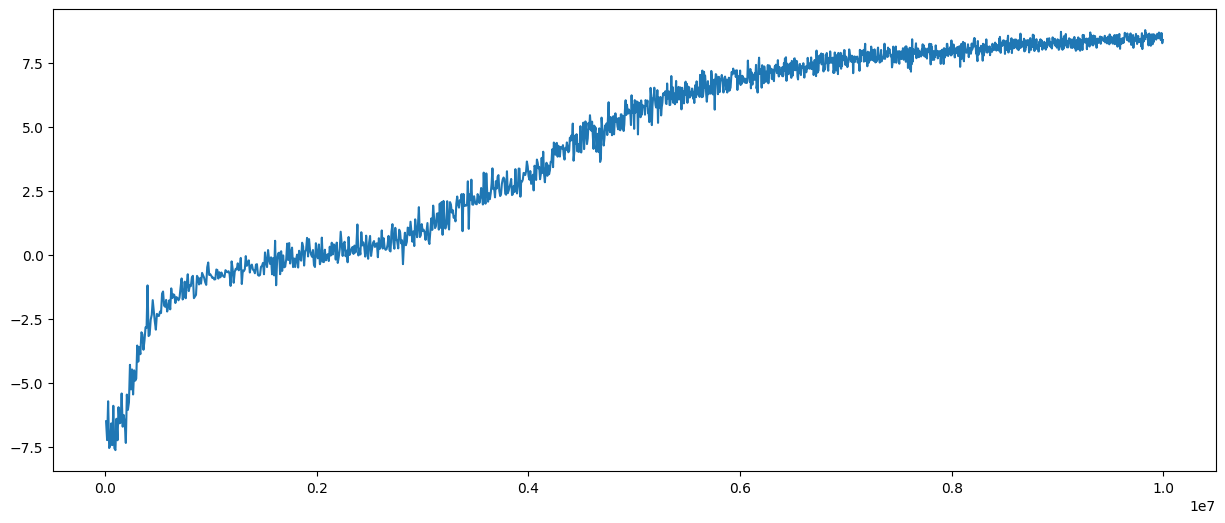

run29.csv


100%|██████████████████████████████████████| 2035/2035 [00:02<00:00, 715.54it/s]


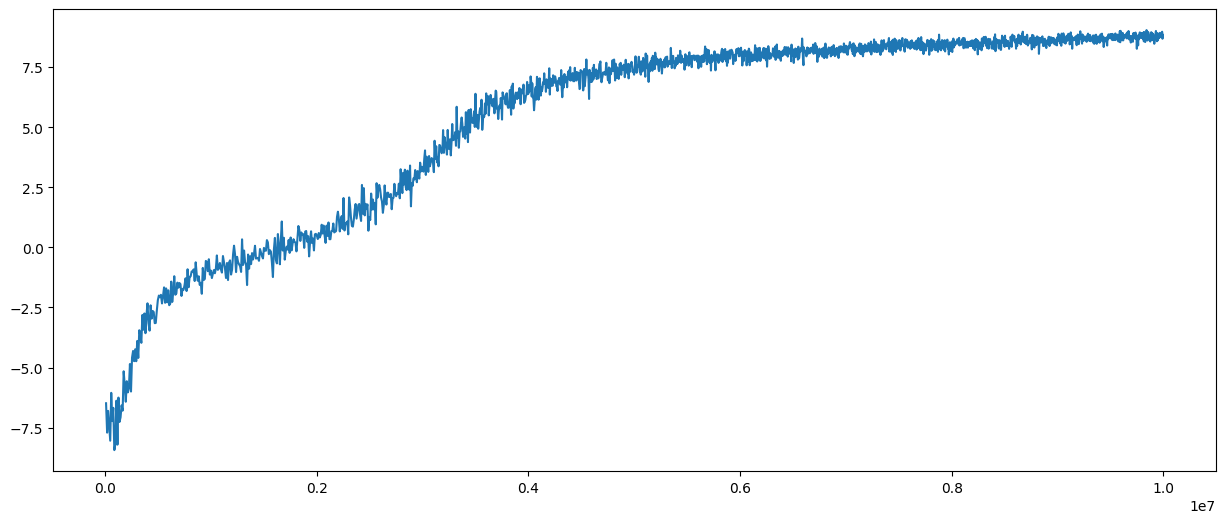

run20.csv


100%|██████████████████████████████████████| 1923/1923 [00:02<00:00, 683.77it/s]


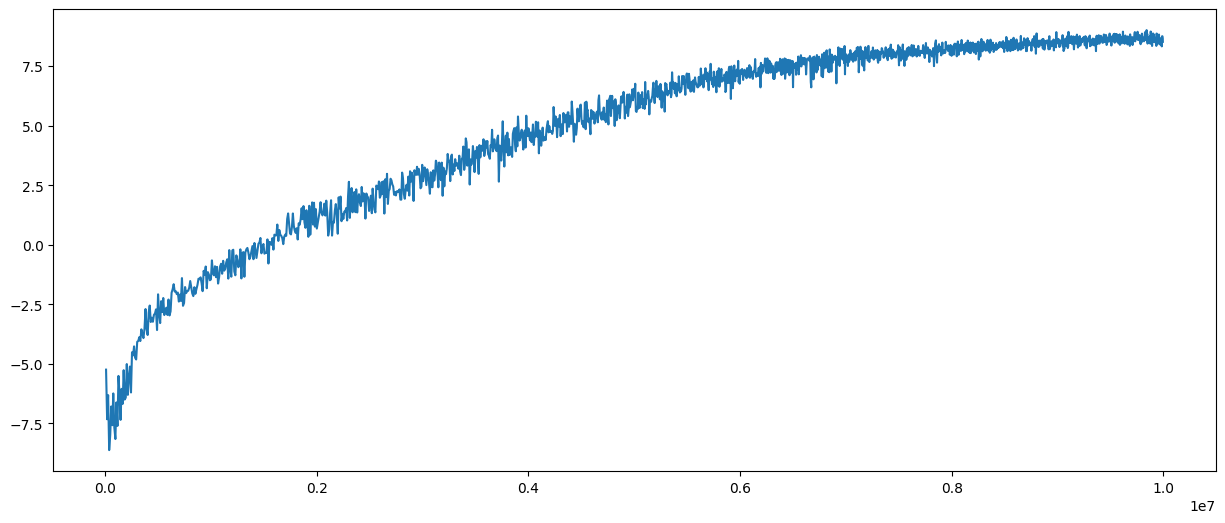

run30.csv


100%|██████████████████████████████████████| 2062/2062 [00:03<00:00, 647.57it/s]


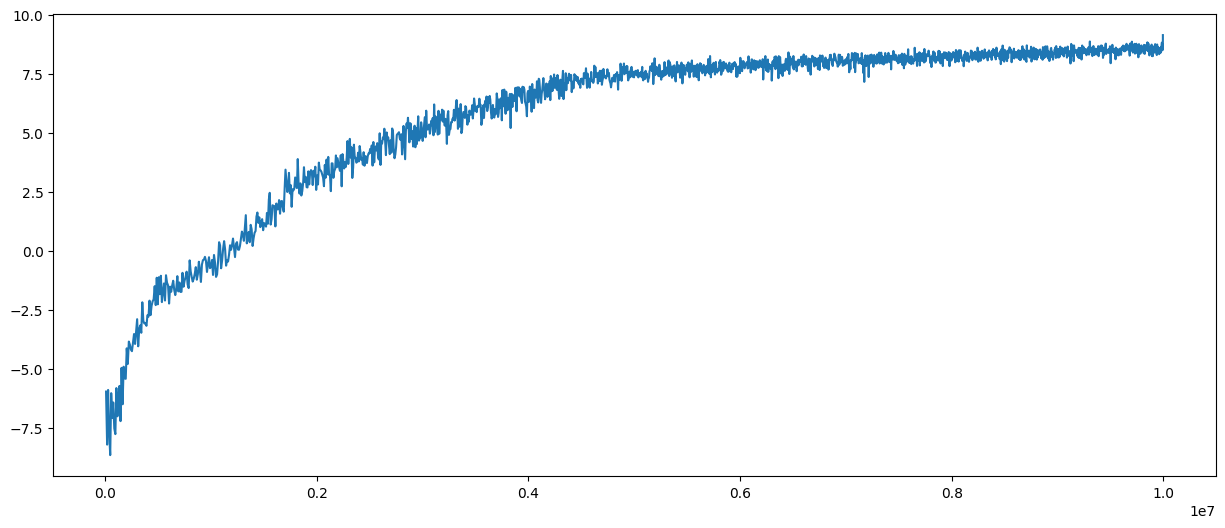

run26.csv


100%|██████████████████████████████████████| 1462/1462 [00:02<00:00, 685.43it/s]


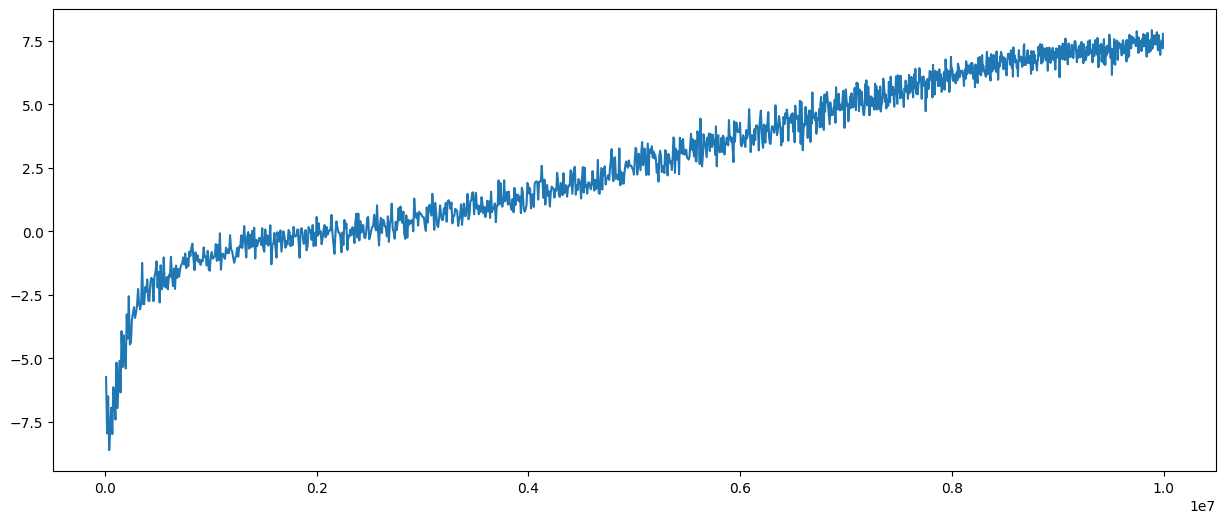

run27.csv


100%|██████████████████████████████████████| 1650/1650 [00:02<00:00, 782.19it/s]


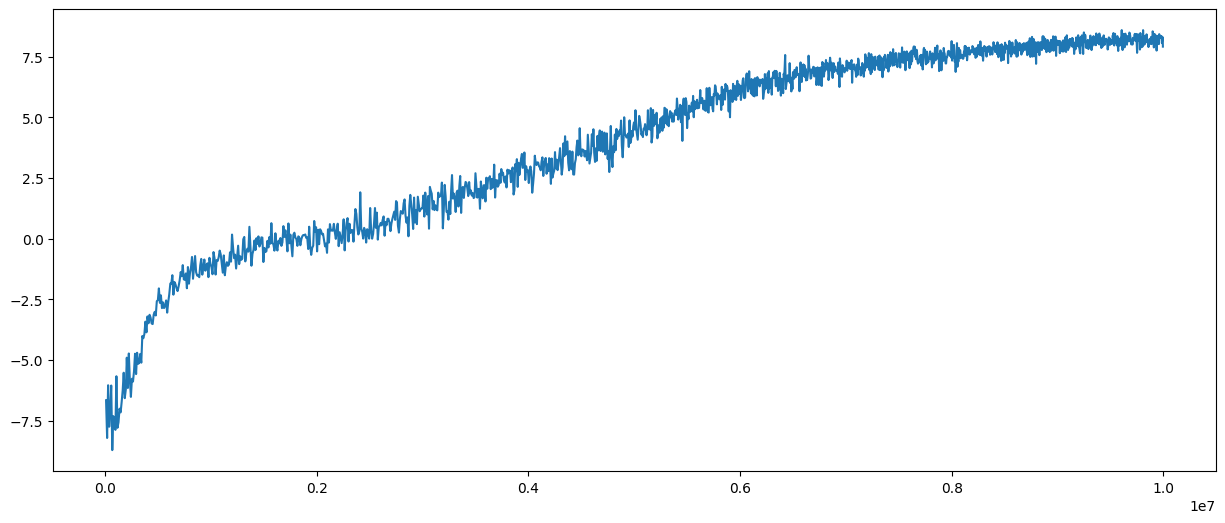

run22.csv


100%|██████████████████████████████████████| 2074/2074 [00:02<00:00, 691.51it/s]


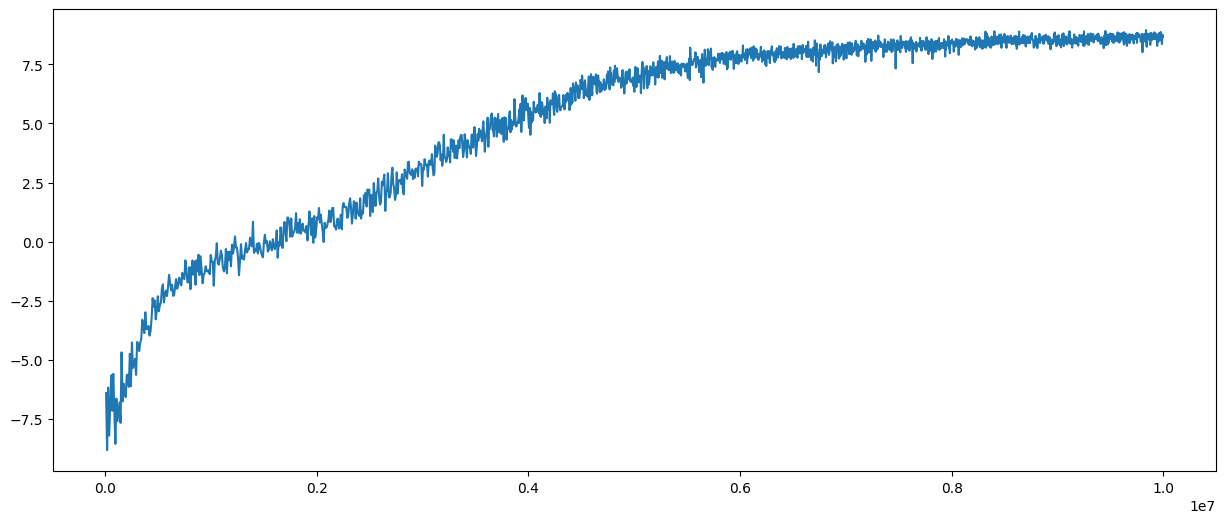

run24.csv


100%|██████████████████████████████████████| 1821/1821 [00:02<00:00, 724.14it/s]


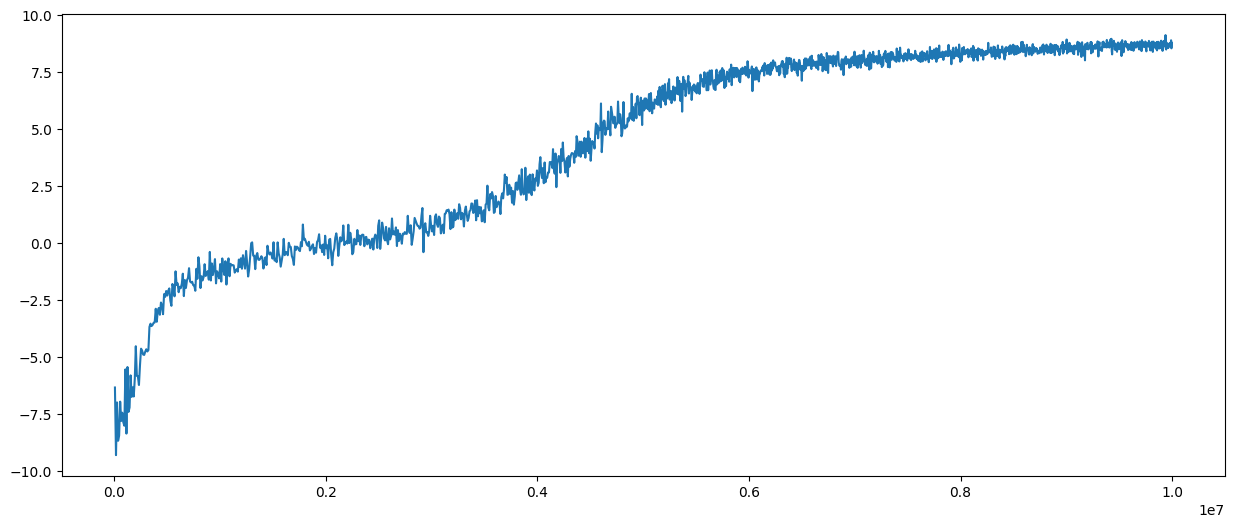

run21.csv


100%|██████████████████████████████████████| 1767/1767 [00:02<00:00, 726.29it/s]


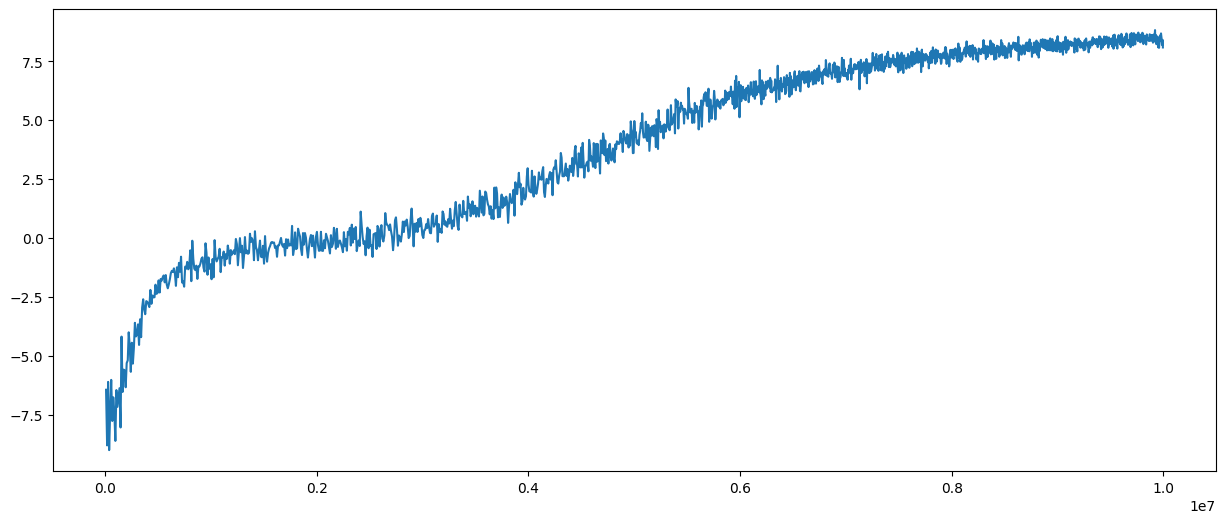

In [5]:
load_plot_runs("../models/magym_PredPrey_new/9o5SA_Diff_noc/train_data/", "Episode return")

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run7.csv - run9.csv - run11.csv - run16.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run17.csv - run28.csv - run23.csv - run18.csv - run19.csv - run16.csv - run25.csv - run29.csv - run20.csv - run30.csv - run26.csv - run27.csv - run22.csv - run24.csv - run21.csv - 

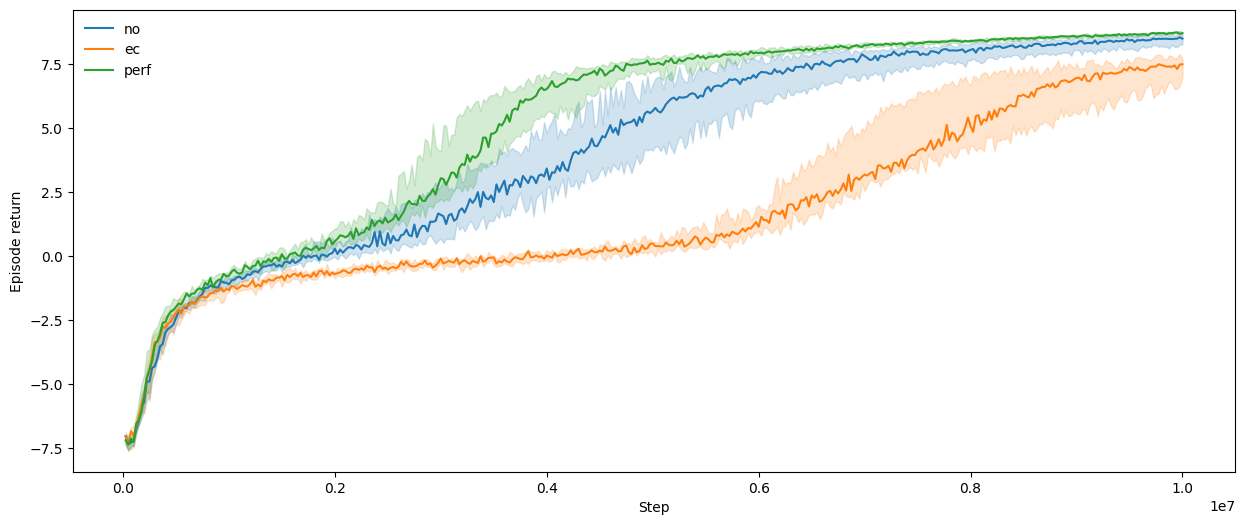

In [2]:
perf = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_perf/train_data/", 
    "perf", 
    25000)
ec = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_ec2/train_data/", 
    "ec", 
    25000)
noc = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_noc/train_data/", 
    "no", 
    25000)

plot_runs([noc, ec, perf], y="Episode return", estim="median", err="ci")